# BWR Micro Core

**Inputs** 

- `PSZ`: Fuel bundle region Power Shaping Zone (PSZ).
- `DOM`:  Fuel bundle region Dominant zone (DOM).
- `vanA`: Fuel bundle region vanishing zone A (VANA).
- `vanB`: Fuel bundle region vanishing zone B (VANB)
- `subcool`: Represents moderator inlet conditions. Core inlet subcooling interpreted to be at the steam dome pressure (i.e., not core-averaged pressure). The input value for subcooling will automatically be increased to account for this fact. (Btu/lb)?
- `CRD`: Defines the position of all control rod groups (banks).
- `flow_rate`: Defines essential global design data for rated coolant mass flux for the active core, $\frac{kg}{(cm^{2}-hr)}$. Coolant   mass flux equals active core flow divided by core cross-section area. Core cross-section area is DXA 2 times the number of assemblies.
- `power_density`: Defines essential global design data for rated power density using cold dimensions, $(\frac{kw}{liter})$.
- `VFNGAP`: Defines the ratio of narrow water gap width to the sum of the narrow and wide water gap widths.

**Output**

- `K-eff`:  Reactivity coefficient k-effective, the effective neutron multiplication factor.
- `Max3Pin`: Maximum planar-averaged pin power peaking factor.
- `Max4Pin`: maximum pin-power peaking factor, $F_{q}$, (which includes axial intranodal peaking).
- `F-delta-H`: Ratio of max-to-average enthalpy rise in a channel.
- `Max-Fxy`: Maximum radial pin-power peaking factor.

    The data set consists of 2000 data points with 9 inputs and 5 outputs. This data set was constructed through uniform and normal sampling of the 9 input parameters for a boiling water reactor (BWR) micro-core. These samples were then used to solve for reactor characteristic changes in heat distribution and neutron flux. This BWR micro-core consists of 4 radially and axially heterogenous assemblies of the same type constructed in a 2x2 grid with a control blade placed in the center. A single assembly composition can be seen in the figure below. A single assembly was brocken into seven zones where each zones 2D radial cross sectional information was constructed using CASMO-4. These cross sectional libraries were then processed through CMSLINK for SIMULATE-3 to interpret. The core geometry and physics was implemented and modeled using SIMULATE-3.

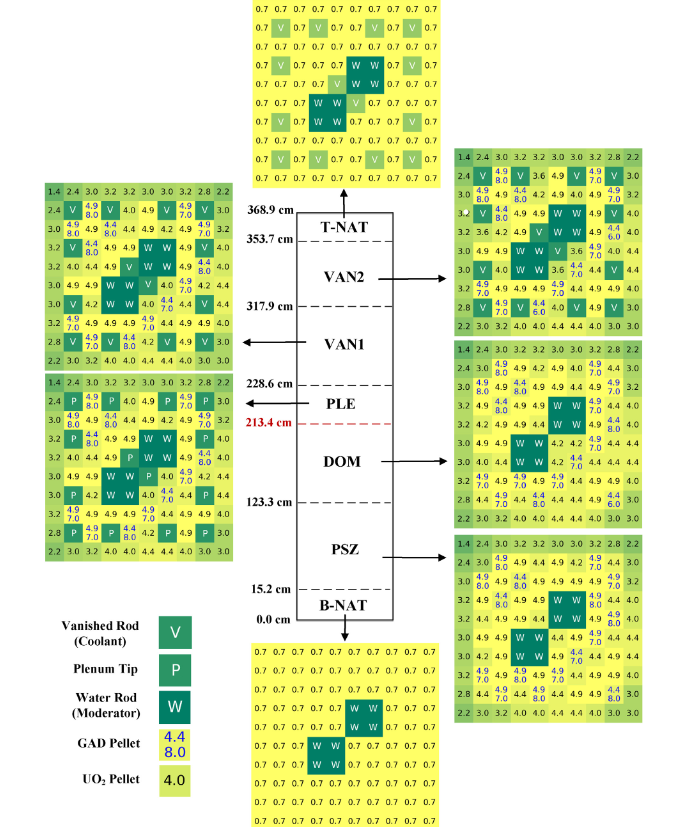

In [3]:
import pyMAISE as mai
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import uniform, randint
from sklearn.model_selection import ShuffleSplit

# Plot settings
matplotlib_settings = {
    "font.size": 14,
    "legend.fontsize": 12,
}
plt.rcParams.update(**matplotlib_settings)

## pyMAISE Initialization

Starting any pyMAISE job requires initialization, this includes the definition of global settings used throughout pyMAISE. For this problem the pyMAISE defaults are used:

- `verbosity`: 0 $\rightarrow$ pyMAISE prints no outputs,
- `random_state`: None $\rightarrow$ No random seed is set,
- `test_size`: 0.3 $\rightarrow$ 30% of the data is used for testing,
- `num_configs_saved`: 5 $\rightarrow$ The top 5 hyper-parameter configurations are saved for each model.

The settings are initialized and the heat conduction preprocessor specific to this data set is retrieved.

In [24]:
global_settings = mai.settings.init()
preprocessor = mai.load_BWR()

The BWR micro reactor data set has 9 inputs


In [25]:
preprocessor.inputs.head()

,PSZ,DOM,vanA,vanB,subcool,CRD,flow_rate,power_density,VFNGAP
0,120.334,216.336,338.763,332.827,24.168,15,250.161,66.250,0.222
1,137.906,198.764,349.531,322.059,22.435,30,253.792,66.044,0.393
2,131.235,205.435,317.283,354.307,24.234,16,255.631,65.839,0.432
3,127.169,209.501,303.856,367.734,27.501,47,252.619,63.828,0.360
4,113.670,223.000,306.145,365.445,22.188,8,256.789,64.326,0.442


and 5 outputs with 2000 samples

In [26]:
preprocessor.outputs.head()

,K-eff,Max3Pin,Max4Pin,F-delta-H,Max-Fxy
0,0.95455,5.105,5.303,1.861,1.899
1,0.98576,2.839,2.904,1.436,1.816
2,0.95237,5.161,5.430,1.846,1.903
3,0.99724,2.500,2.575,1.246,1.584
4,0.87466,6.259,6.635,1.580,1.900


To better understand the data here is a correlation matrix of the data.

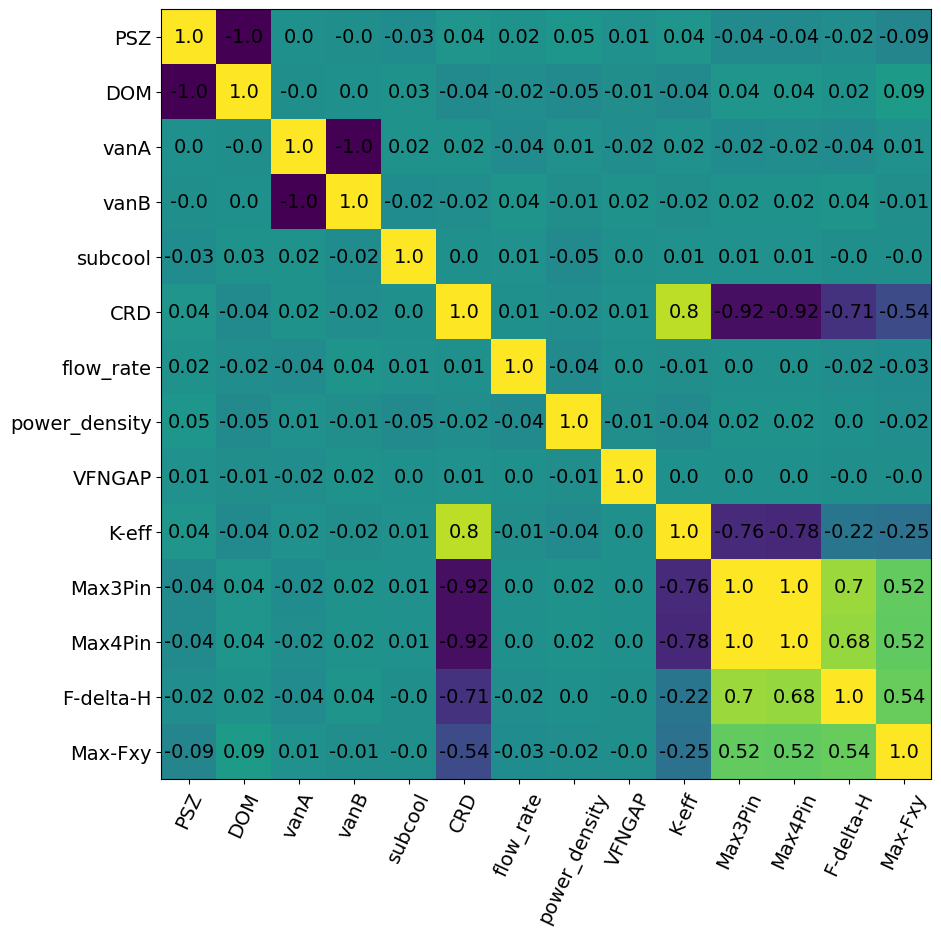

In [27]:
fig, ax = plt.subplots(figsize=(15,10))
fig, ax = preprocessor.correlation_matrix(fig=fig, ax=ax, colorbar=False, annotations=True)

As expected there is a strong negative correlation between control rod position (CRD) and the peaking factors. There is also a strong positive correlation between control rod position and k effective.

Prior to model training the data is min-max scaled to make each feature's effect size is comparable. Additionally, this can improve the performance of some models.


In [28]:
data = preprocessor.min_max_scale()

# Model Initialization
Given this data set has a multi-dimensional output we will compare the performance of 7 machine learning (ML) models:

- Linear regression: `linear`,
- Lasso regression: `lasso`,
- Decision tree regression: `dtree`,
- Random forest regression: `rforest`,
- K-nearest neighbors regression: `knn`,
- Sequential dense neural networks: `nn`.

For hyper-parameter tuning each model must be initialized. We will use the Scikit-learn defaults for the classical ML models (`linear`, `lasso`, `dtree`, `rforest`, and `knn`); therefore, they are only specified in the `models` parameter of the `model_settings` dictionary. However, we must specify many parameters for the `nn` model that define the layers, optimizer, and training.

In [29]:
model_settings = {
    "models": ["linear", "lasso", "dtree", "knn", "rforest", "nn"],
    "nn": { 
        # Sequential
        "num_layers": 4,
        "dropout": True,
        "rate": 0.5,
        "validation_split": 0.15,
        "loss": "mean_absolute_error",
        "metrics": ["mean_absolute_error"],
        "batch_size": 8,
        "epochs": 50,
        "warm_start": True,
        "jit_compile": False,
        # Starting Layer
        "start_num_nodes": 100,
        "start_kernel_initializer": "normal",
        "start_activation": "relu",
        "input_dim": preprocessor.inputs.shape[1], # Number of inputs
        # Middle Layers
        "mid_num_node_strategy": "linear", # Middle layer nodes vary linearly from 'start_num_nodes' to 'end_num_nodes'
        "mid_kernel_initializer": "normal",
        "mid_activation": "relu",
        # Ending Layer
        "end_num_nodes": preprocessor.outputs.shape[1], # Number of outputs
        "end_activation": "linear",
        "end_kernel_initializer": "normal",
        # Optimizer
        "optimizer": "adam",
        "learning_rate": 5e-4,
    },
}
tuning = mai.Tuning(data=data, model_settings=model_settings)

# Hyper-parameter Tuning

While three hyper-parameter tuning functions are supported (grid_search, random_search, and bayesian_search), random_search and bayesian_search are used for the classical ML and nn models, respectively. random_search randomly samples a defined parameter space and the number of models generated is easily defined. A large number of classical models are generated through random_search as they are relatively quick to train. However, the prohibative time required to train neural networks makes bayesian_search more appealing as the search converges to the optimal hyper-parameters in relatively few iterations. The hyper-parameter search spaces are outlined below, many with Scipy uniform distributions. Cross validation is used in both search methods to eliminate bias from the data set.

In [30]:
random_search_spaces = {
    "lasso": {
        "alpha": uniform(loc=0.0001, scale=0.0099), # 0.0001 - 0.01
    },
    "dtree": {
        "max_depth": randint(low=5, high=50), # 5 - 50
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
    },
    "rforest": {
        "n_estimators": randint(low=50, high=200), # 50 - 200
        "criterion": ["squared_error", "absolute_error", "poisson"],
        "min_samples_split": randint(low=2, high=20), # 2 - 20
        "min_samples_leaf": randint(low=1, high=20), # 1 - 20
        "max_features": [None, "sqrt", "log2", 2, 4, 6],
    },
    "knn": {
        "n_neighbors": randint(low=1, high=20), # 1 - 20
        "weights": ["uniform", "distance"],
        "leaf_size": randint(low=1, high=30), # 1 - 30
        "p": randint(low=1, high=10), # 1 - 10
    },
}
bayesian_search_spaces = {
    "nn": {
        "mid_num_node_strategy": ["constant", "linear"],
        "dropout": [True, False],
        "batch_size": [8, 64],
        "learning_rate": [1e-5, 0.01],
        "num_layers": [2, 8],
        "start_num_nodes": [25, 500],
    },
}

start = time.time()
random_search_configs = tuning.random_search(
    param_spaces=random_search_spaces, 
    models=["linear"] + list(random_search_spaces.keys()), 
    n_iter=300, 
    cv=ShuffleSplit(n_splits=5, test_size=0.25, random_state=global_settings.random_state),
)
bayesian_search_configs = tuning.bayesian_search(
    param_spaces=bayesian_search_spaces,
    models=bayesian_search_spaces.keys(),
    n_iter=50,
    cv=5,
)
stop = time.time()
print("Hyper-parameter tuning took " + str((stop - start) / 60) + " minutes to process.")

Hyper-parameter tuning search space was not provided for linear, doing manual fit
Hyper-parameter tuning took 86.78759005467097 minutes to process.


With the conclusion of training we can see training results for each iteration using the convergence_plot function. For example here is Bayesian search of neural networks:

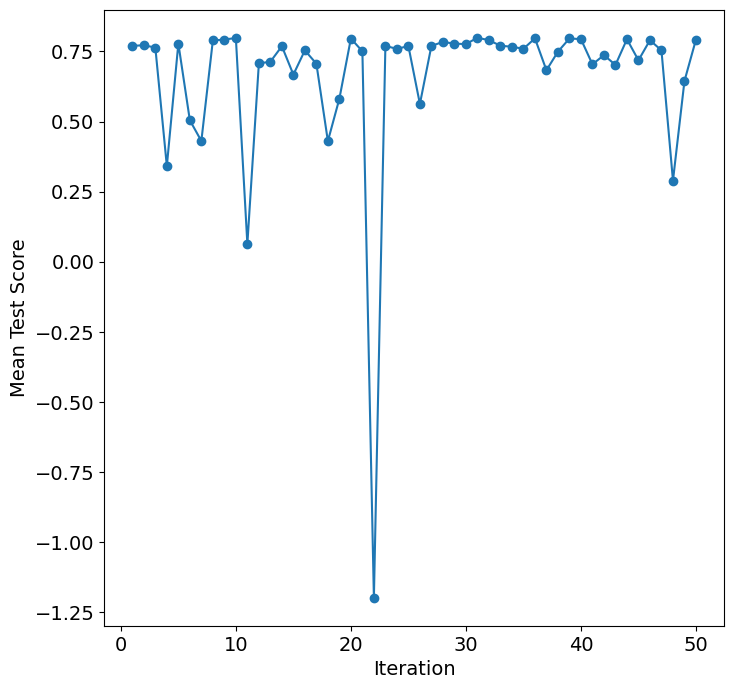

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
ax = tuning.convergence_plot(model_types="nn")

Fewer than 30 iterations were required to converge to the optimal parameter configurations.

## Model Post-processing

With the models tuned and the top `num_configs_saved` saved, we can now pass these models to the `PostProcessor` for model comparison and analysis. We will increase the `epochs` of the `nn` models for better performance.

In [32]:
new_model_settings = {
    "nn": {"epochs": 200}
}
postprocessor = mai.PostProcessor(
    data=data, 
    models_list=[random_search_configs, bayesian_search_configs], 
    new_model_settings=new_model_settings,
    yscaler=preprocessor.yscaler,
)

To compare the performance of these models we will compute 4 metrics for both the training and testing data: 

- mean squared error `MSE` $=\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2$, 
- root mean squared error `RMSE` $=\sqrt{\frac{1}{n}\sum^n_{i = 1}(y_i - \hat{y_i})^2}$,
- mean absolute error `MAE` = $=\frac{1}{n}\sum^n_{i = 1}|y_i - \hat{y_i}|$,
- and r-squared `R2` $=1 - \frac{\sum^n_{i = 1}(y_i - \hat{y_i})^2}{\sum^n_{i = 1}(y_i - \bar{y_i})^2}$,

where $y$ is the actual outcome, $\bar{y}$ is the average outcome, $\hat{y}$ is the model predicted outcome, and $n$ is the number of observations. The averaged performance metrics are shown below.

In [33]:
postprocessor.metrics()

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
10,dtree,"{'max_depth': 10, 'max_features': None, 'min_s...",0.990065,0.029325,0.007171,0.084683,0.968441,0.056375,0.041258,0.203120
6,dtree,"{'max_depth': 23, 'max_features': None, 'min_s...",0.989088,0.030553,0.007748,0.088024,0.967995,0.057324,0.041841,0.204551
7,dtree,"{'max_depth': 20, 'max_features': None, 'min_s...",0.988778,0.031133,0.008408,0.091693,0.967823,0.057460,0.042727,0.206706
8,dtree,"{'max_depth': 37, 'max_features': None, 'min_s...",0.994997,0.020181,0.003496,0.059128,0.967457,0.056391,0.044830,0.211730
9,dtree,"{'max_depth': 24, 'max_features': None, 'min_s...",0.994997,0.020181,0.003496,0.059128,0.967416,0.056598,0.045090,0.212344
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.990724,0.028921,0.007129,0.084435,0.966929,0.054329,0.039736,0.199339
14,rforest,"{'criterion': 'squared_error', 'max_features':...",0.987777,0.034477,0.010192,0.100958,0.965517,0.057322,0.041762,0.204357
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.989018,0.032604,0.009257,0.096213,0.965015,0.056036,0.042186,0.205393
12,rforest,"{'criterion': 'squared_error', 'max_features':...",0.995220,0.020042,0.004100,0.064031,0.963209,0.053987,0.041549,0.203836
13,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.986839,0.034163,0.010585,0.102883,0.962634,0.057911,0.042445,0.206021


Given the top performing models are `decission tree (dtree)` and `random forest (rforest)` this data set's outputs are non-linear with their inputs. `nn` performed well, but not amazing. Further analysis will be done later to see which outputs metric brought the values down when averaged. Performance quickly drops off with `linear`, `lasso`, and `knn`. We can look specifically at the performance for each output:

In [34]:
postprocessor.metrics(y="K-eff")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,nn,"{'batch_size': 63, 'dropout': 0, 'learning_rat...",0.992924,0.004380,0.000055,0.007411,0.990673,0.004628,0.000076,0.008734
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.997210,0.002391,0.000022,0.004654,0.988101,0.003974,0.000097,0.009864
14,rforest,"{'criterion': 'squared_error', 'max_features':...",0.996517,0.002671,0.000027,0.005199,0.988051,0.004045,0.000098,0.009885
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.996609,0.002647,0.000026,0.005130,0.987886,0.004016,0.000099,0.009953
12,rforest,"{'criterion': 'squared_error', 'max_features':...",0.998614,0.001656,0.000011,0.003280,0.987499,0.003950,0.000102,0.010111
10,dtree,"{'max_depth': 10, 'max_features': None, 'min_s...",0.995840,0.002559,0.000032,0.005682,0.987025,0.004326,0.000106,0.010301
6,dtree,"{'max_depth': 23, 'max_features': None, 'min_s...",0.995218,0.002748,0.000037,0.006092,0.986637,0.004408,0.000109,0.010454
7,dtree,"{'max_depth': 20, 'max_features': None, 'min_s...",0.995132,0.002807,0.000038,0.006147,0.986629,0.004419,0.000109,0.010457
13,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.996342,0.002675,0.000028,0.005328,0.985941,0.004349,0.000115,0.010722
8,dtree,"{'max_depth': 37, 'max_features': None, 'min_s...",0.997690,0.001887,0.000018,0.004234,0.984397,0.004575,0.000128,0.011296


For K-eff, random forest out performed decission tree. Knn seems to be overfit and linear did poorly which is expected for a non-linear data set. Neural Networks performed the best.

In [35]:
postprocessor.metrics(y="Max3Pin")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,nn,"{'batch_size': 63, 'dropout': 0, 'learning_rat...",0.986191,0.079720,0.034154,0.184808,0.971577,0.103373,0.072366,0.269010
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.993406,0.062617,0.016309,0.127706,0.961896,0.121188,0.097015,0.311472
12,rforest,"{'criterion': 'squared_error', 'max_features':...",0.996268,0.043610,0.009229,0.096068,0.960371,0.121073,0.100897,0.317643
10,dtree,"{'max_depth': 10, 'max_features': None, 'min_s...",0.992857,0.065201,0.017666,0.132912,0.960364,0.127502,0.100914,0.317669
14,rforest,"{'criterion': 'squared_error', 'max_features':...",0.990462,0.075151,0.023588,0.153585,0.959923,0.128384,0.102037,0.319432
6,dtree,"{'max_depth': 23, 'max_features': None, 'min_s...",0.992241,0.068077,0.019190,0.138528,0.959690,0.129975,0.102630,0.320360
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.991530,0.070696,0.020948,0.144734,0.959585,0.125083,0.102897,0.320776
13,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.990131,0.073576,0.024408,0.156229,0.959327,0.128579,0.103555,0.321799
7,dtree,"{'max_depth': 20, 'max_features': None, 'min_s...",0.991596,0.069395,0.020785,0.144172,0.958962,0.130241,0.104485,0.323241
8,dtree,"{'max_depth': 37, 'max_features': None, 'min_s...",0.996524,0.044739,0.008597,0.092721,0.957007,0.128202,0.109462,0.330850


Max3Pin had similiar performance to K-eff. Neural nets did slightly poorer, but still produced the best results.

In [36]:
postprocessor.metrics(y="Max4Pin")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
22,nn,"{'batch_size': 63, 'dropout': 0, 'learning_rat...",0.985243,0.072401,0.042293,0.205652,0.973325,0.099881,0.079030,0.281122
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.993359,0.067120,0.019033,0.137961,0.965950,0.127040,0.100879,0.317615
10,dtree,"{'max_depth': 10, 'max_features': None, 'min_s...",0.993782,0.065939,0.017820,0.133491,0.964793,0.129329,0.104308,0.322967
6,dtree,"{'max_depth': 23, 'max_features': None, 'min_s...",0.993327,0.067937,0.019124,0.138291,0.964387,0.131342,0.105511,0.324825
14,rforest,"{'criterion': 'squared_error', 'max_features':...",0.990589,0.079824,0.026970,0.164227,0.964250,0.133328,0.105917,0.325449
12,rforest,"{'criterion': 'squared_error', 'max_features':...",0.996118,0.046612,0.011125,0.105473,0.964210,0.126188,0.106036,0.325632
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.991285,0.075830,0.024977,0.158041,0.963810,0.130855,0.107220,0.327445
13,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.990203,0.078216,0.028076,0.167560,0.963637,0.133826,0.107734,0.328229
7,dtree,"{'max_depth': 20, 'max_features': None, 'min_s...",0.992734,0.069303,0.020823,0.144303,0.963509,0.131951,0.108113,0.328805
8,dtree,"{'max_depth': 37, 'max_features': None, 'min_s...",0.996966,0.045941,0.008696,0.093253,0.961675,0.129972,0.113546,0.336966


Max4Pin results are very similiar to Max3Pin with once again `nn` doing the best.

In [37]:
postprocessor.metrics(y="F-delta-H")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
12,rforest,"{'criterion': 'squared_error', 'max_features':...",0.997526,0.005729,0.000101,0.010052,0.987574,0.012968,0.000512,0.022628
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.994777,0.008539,0.000213,0.014607,0.987208,0.013532,0.000527,0.022960
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.993744,0.009477,0.000256,0.015986,0.986818,0.014000,0.000543,0.023306
14,rforest,"{'criterion': 'squared_error', 'max_features':...",0.992925,0.010169,0.000289,0.017000,0.985633,0.014625,0.000592,0.024332
13,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.992267,0.010958,0.000316,0.017774,0.984739,0.015454,0.000629,0.025078
22,nn,"{'batch_size': 63, 'dropout': 0, 'learning_rat...",0.984747,0.017223,0.000623,0.024961,0.980467,0.019306,0.000805,0.028371
7,dtree,"{'max_depth': 20, 'max_features': None, 'min_s...",0.992307,0.009634,0.000314,0.017727,0.980347,0.014987,0.000810,0.028458
6,dtree,"{'max_depth': 23, 'max_features': None, 'min_s...",0.992343,0.009572,0.000313,0.017685,0.979749,0.015229,0.000835,0.028888
10,dtree,"{'max_depth': 10, 'max_features': None, 'min_s...",0.993464,0.008639,0.000267,0.016340,0.979536,0.015004,0.000843,0.029039
9,dtree,"{'max_depth': 24, 'max_features': None, 'min_s...",0.996732,0.005381,0.000133,0.011553,0.978187,0.013965,0.000899,0.029981


F-delta-H also had very good performance in random forest and decision tree with slightly poorer results for neural nets. K nearest neighbors is still overfit.

In [38]:
postprocessor.metrics(y="Max-Fxy")

,Model Types,Parameter Configurations,Train R2,Train MAE,Train MSE,Train RMSE,Test R2,Test MAE,Test MSE,Test RMSE
9,dtree,"{'max_depth': 24, 'max_features': None, 'min_s...",0.987073,0.002955,0.000036,0.005985,0.956337,0.005243,0.000103,0.010158
8,dtree,"{'max_depth': 37, 'max_features': None, 'min_s...",0.987073,0.002955,0.000036,0.005985,0.956266,0.005268,0.000103,0.010166
10,dtree,"{'max_depth': 10, 'max_features': None, 'min_s...",0.974384,0.004285,0.000071,0.008425,0.950486,0.005714,0.000117,0.010817
7,dtree,"{'max_depth': 20, 'max_features': None, 'min_s...",0.972120,0.004529,0.000077,0.008790,0.949668,0.005703,0.000119,0.010906
6,dtree,"{'max_depth': 23, 'max_features': None, 'min_s...",0.972313,0.004433,0.000077,0.008759,0.949513,0.005668,0.000119,0.010923
11,rforest,"{'criterion': 'squared_error', 'max_features':...",0.974867,0.003938,0.000070,0.008346,0.931491,0.005910,0.000162,0.012724
14,rforest,"{'criterion': 'squared_error', 'max_features':...",0.968390,0.004569,0.000088,0.009359,0.929727,0.006228,0.000166,0.012886
15,rforest,"{'criterion': 'squared_error', 'max_features':...",0.971921,0.004369,0.000078,0.008821,0.926977,0.006228,0.000173,0.013136
13,rforest,"{'criterion': 'poisson', 'max_features': None,...",0.965251,0.005392,0.000096,0.009813,0.919525,0.007347,0.000190,0.013790
12,rforest,"{'criterion': 'squared_error', 'max_features':...",0.987575,0.002603,0.000034,0.005868,0.916390,0.005757,0.000198,0.014056


Max-Fxy results differed from the rest. Decission tree had an R2 of 0.97 instead of 0.99 and random forest has similiar results. The big shock is in neural nets where the model performed at an R-squared of about 0.35, which is extremely poor.

In [39]:
for model in model_settings["models"]:
    print(postprocessor.get_params(model_type=model), "\n")

  Model Types  copy_X  fit_intercept n_jobs   normalize  positive
0      linear    True           True   None  deprecated     False 

  Model Types     alpha
0       lasso  0.000608 

  Model Types  max_depth max_features  min_samples_leaf  min_samples_split
0       dtree         24         None                 3                  3 

  Model Types  leaf_size  n_neighbors  p   weights
0         knn          5           12  2  distance 

  Model Types      criterion max_features  min_samples_leaf  \
0     rforest  squared_error         None                 3   

   min_samples_split  n_estimators  
0                  8           175   

  Model Types  batch_size  dropout  learning_rate mid_num_node_strategy  \
0          nn          64        0       0.008871              constant   

   num_layers  start_num_nodes  
0           2              369   



To visualize the performance of these models we can use the `diagonal_validation_plot` functions to produce diagonal validation plots.

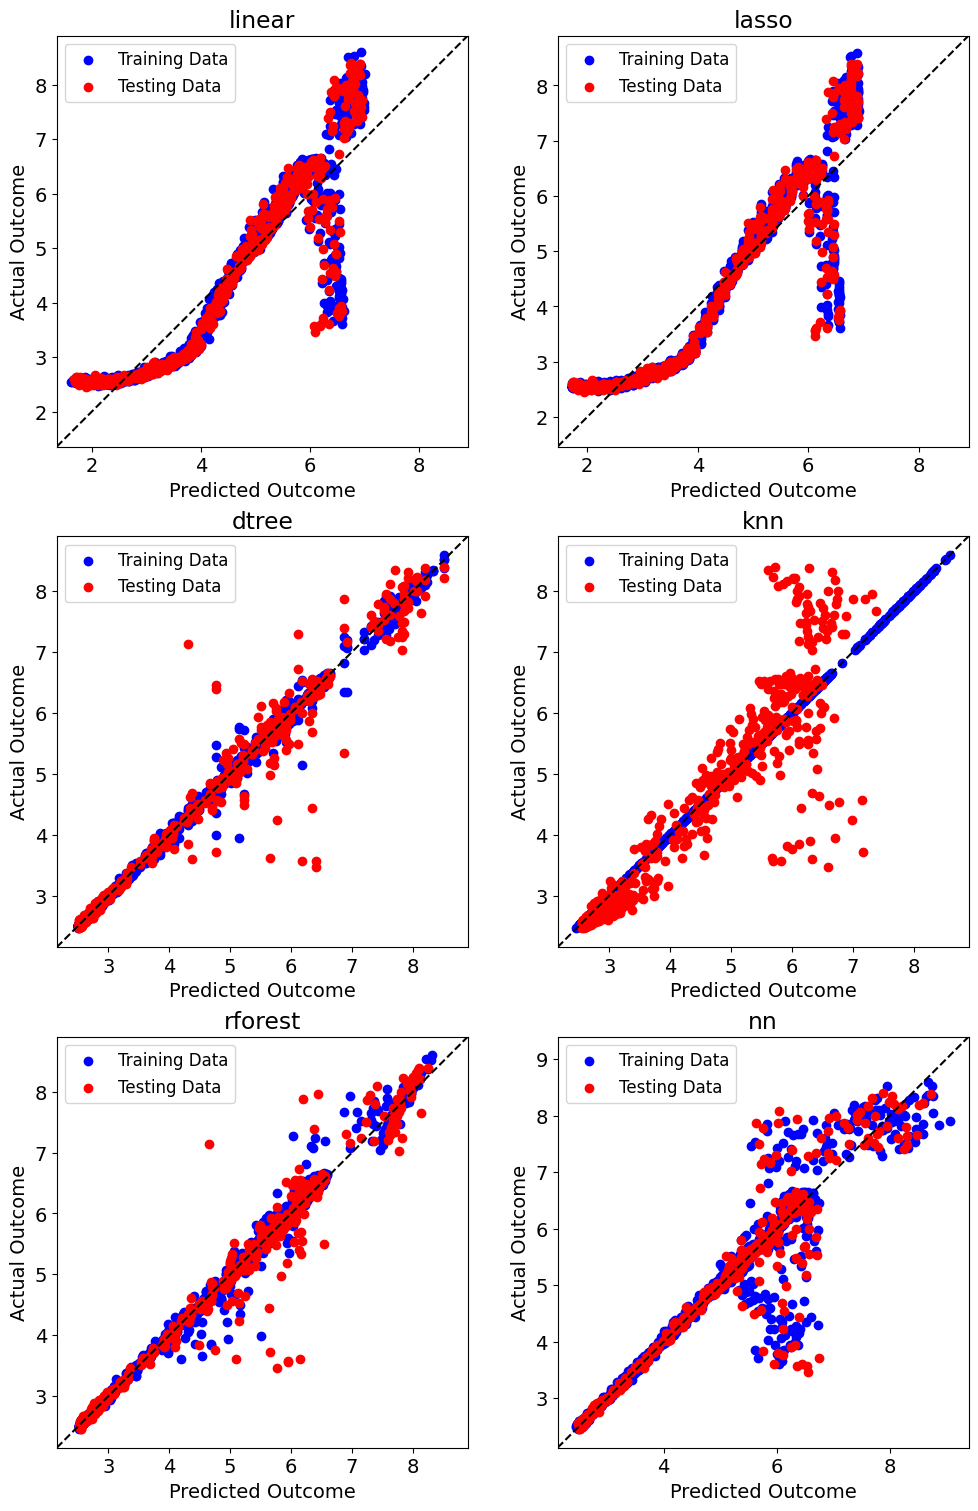

In [40]:
models = np.array([["linear", "lasso"], ["dtree", "knn"], ["rforest", "nn"]])

output = ["Max4Pin"]

fig = plt.figure(constrained_layout=fig, figsize=(10,15))
gs = GridSpec(models.shape[0], models.shape[1], figure=fig)
for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        if models[i, j] != None:
            ax = fig.add_subplot(gs[i, j])
            ax = postprocessor.diagonal_validation_plot(
                model_type=models[i, j], 
                y=output,
            )
            ax.set_title(models[i, j])
            
plt.savefig("diagonaization_bwr.png", dpi=400)

The performance differences between `rforest`/`dtree` with the other models is apparent along with the overfitting of `knn`. The predictions of `rforest` and `dtree` are closely spread along $y=x$ while the `knn` test predictions are over-predicted.

Similarly, the `validation_plot` function produces validation plots that show the absolute relative error for each prediction.

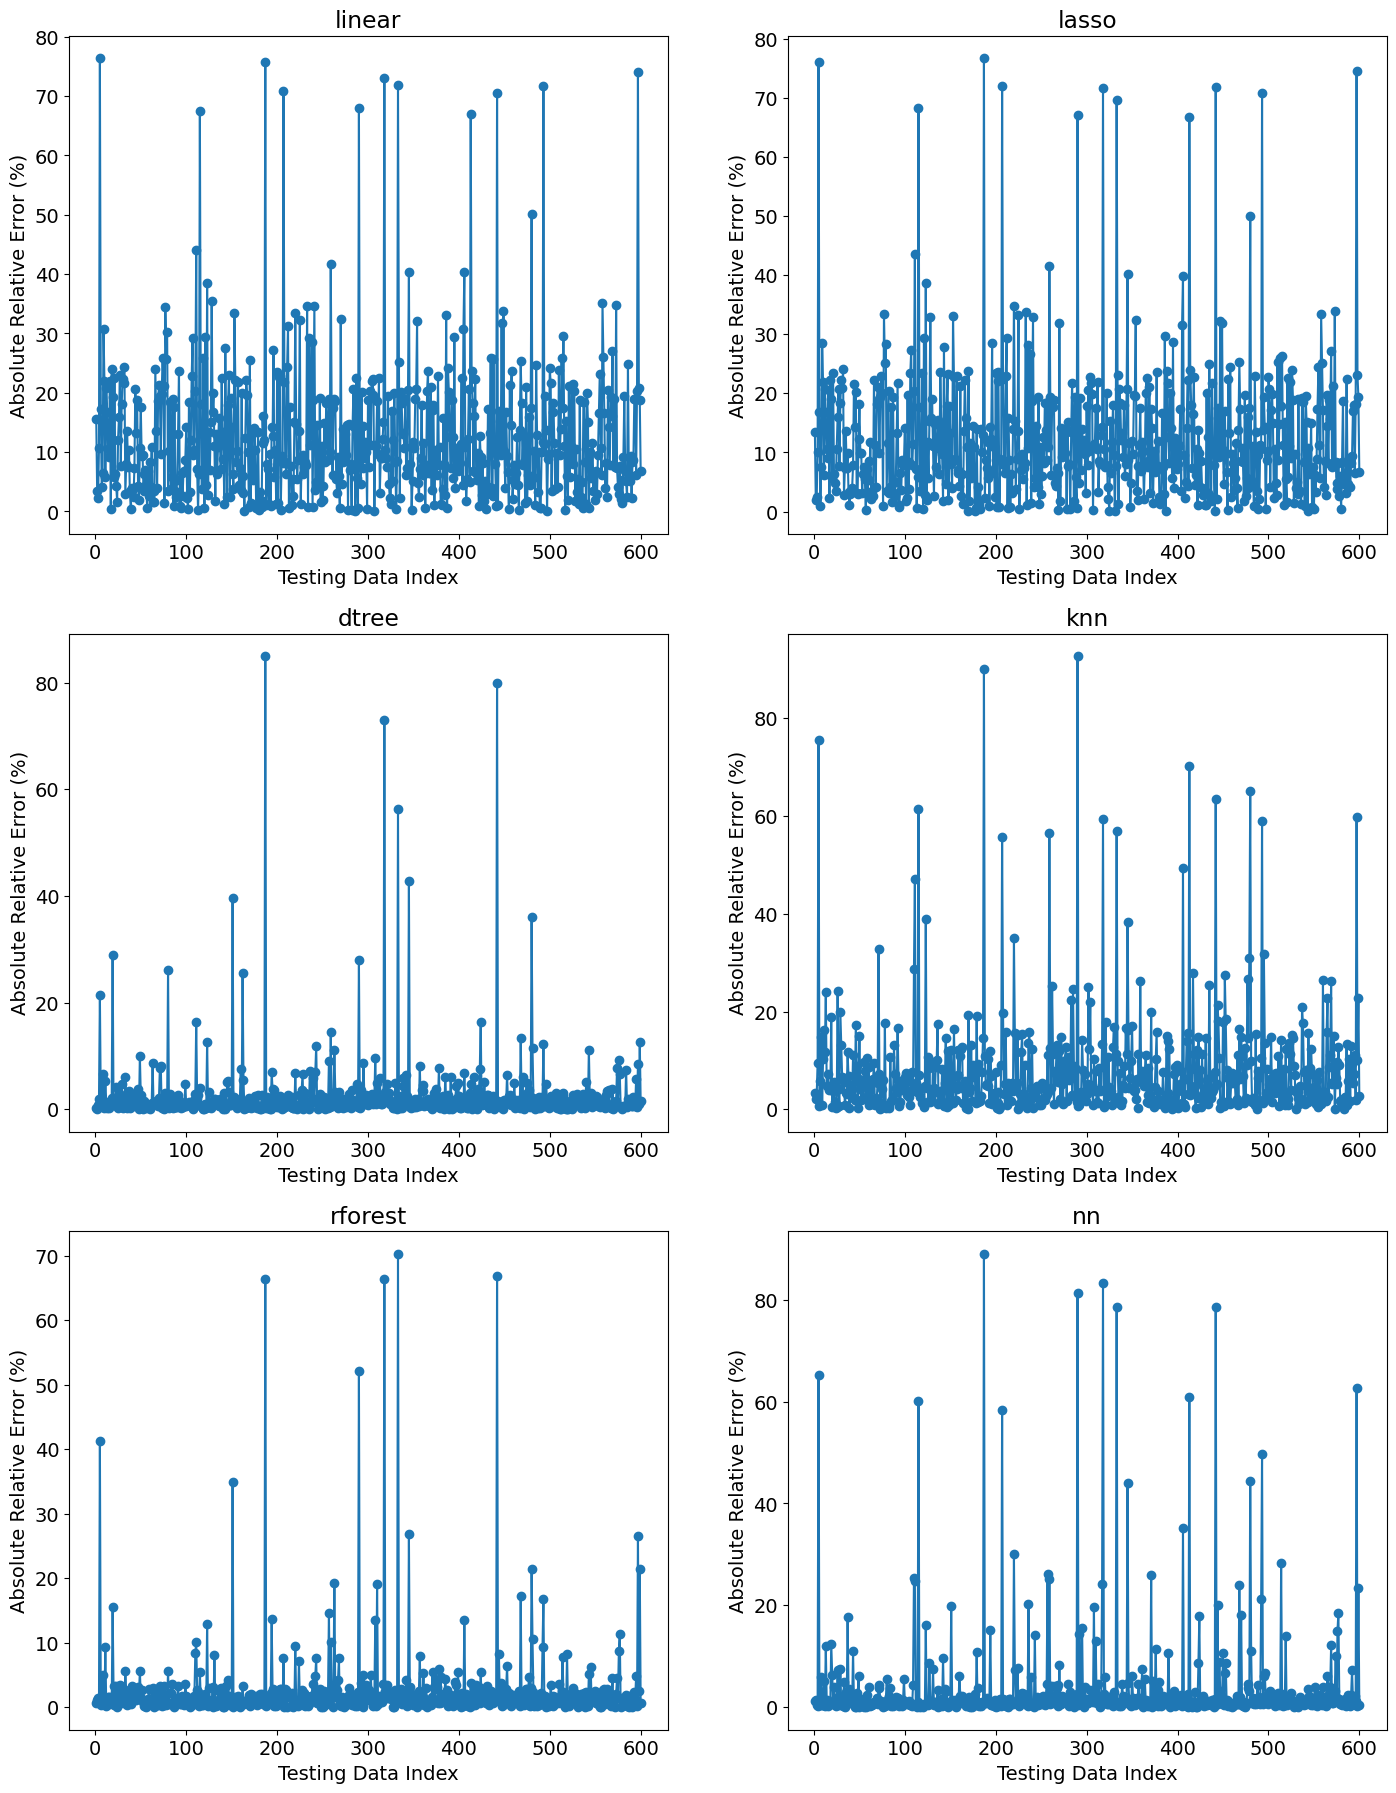

In [41]:
fig, axarr = plt.subplots(models.shape[0], models.shape[1], figsize=(17,22))

y = ["Max4Pin"]

for i in range(models.shape[0]):
    for j in range(models.shape[1]):
        plt.sca(axarr[i, j])
        axarr[i, j] = postprocessor.validation_plot(model_type=models[i, j], y=y)
        axarr[i, j].set_title(models[i, j])     


The performance of the models is best represented by the magnitudes observed on the y-axis; however, even `rforest` and `dtree` get as high as $>3.0\%$ error. 

Finally, the learning curve of the most performant `nn` is shown by `nn_learning_plot`.

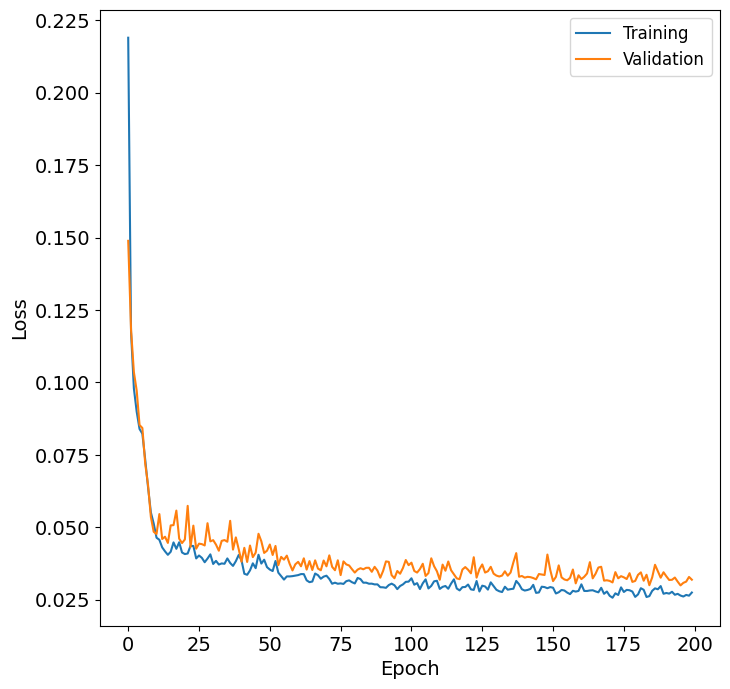

In [42]:
fig, ax = plt.subplots(figsize=(8,8))
ax = postprocessor.nn_learning_plot()

The neural network learning curve above shows that there is no overfitting as traning and validation are very similiar. The converges to 0.025 which is an acceptable number.

## References

1. M. I. Radaideh, B. Forget, and K. Shirvan, “Large-scale design optimisation of boiling water re-
actor bundles with neuroevolution,” Annals of Nuclear Energy, vol. 160, p. 108355, 2021.


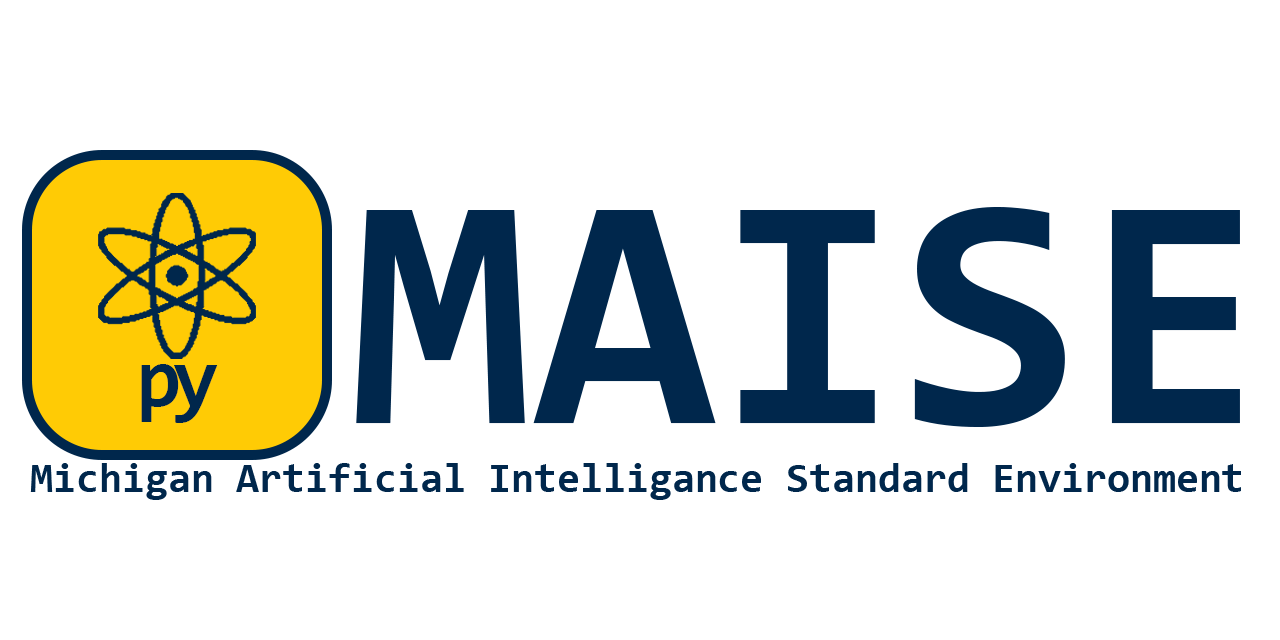